<a href="https://colab.research.google.com/github/thiagobnferraz/SeriesTemporais/blob/main/S%C3%A9ries_Temporais_Thiago_Ferraz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Instalar biblioteca pdarima (análise séries temporais por médias móveis, auto-correlação e variáveis exógenas)

In [355]:
!pip install pmdarima

Importar dependências para tratamento de dados e uso das funções de bibliotecas instaladas

In [356]:
import pandas as pd
import numpy as np
%matplotlib inline

from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima

import warnings
warnings.filterwarnings("ignore")

Carregar os dados no arquivo excel - aba 'Data'

In [357]:
df = pd.read_excel('/content/international_airline_activity_table1_2009tocurrent_0122.xlsx', sheet_name='Data', parse_dates=True)

Visualizar as primeiras linhas do dataframe

In [358]:
df.head()

,Month,Scheduled Operator,Country to/from,Passengers In,Freight In,Mail In,Passengers Out,Freight Out,Mail Out,Year,"<< This year is based on the month selected in cell H2 in sheet ""Totals"" - it is only a calendar year if the month in sheet ""Totals"" is set to December"
0,2009-01-01,Aerolineas Argentinas,Argentina,3021,4.313,0.6,1959,8.311,0,2009,NaN
1,2009-01-01,Aerolineas Argentinas,New Zealand,627,76.26,0,1821,68.539,0,2009,NaN
2,2009-01-01,Air Caledonie,New Caledonia,6658,4.918,0.645,5365,68.621,1.291,2009,NaN
3,2009-01-01,Air Canada,Canada,7489,174.828,0.004,6424,105.191,0.016,2009,NaN
4,2009-01-01,Air China,China,12458,201.314,18.569,11163,142.408,2.93,2009,NaN


Desconsiderar a última coluna, pois não há informações nas linhas

In [359]:
df = df.iloc[: , :-1]

Visualizar as primeiras linhas do datafrafe

In [360]:
df.head(10)

,Month,Scheduled Operator,Country to/from,Passengers In,Freight In,Mail In,Passengers Out,Freight Out,Mail Out,Year
0,2009-01-01,Aerolineas Argentinas,Argentina,3021,4.313,0.6,1959,8.311,0,2009
1,2009-01-01,Aerolineas Argentinas,New Zealand,627,76.26,0,1821,68.539,0,2009
2,2009-01-01,Air Caledonie,New Caledonia,6658,4.918,0.645,5365,68.621,1.291,2009
3,2009-01-01,Air Canada,Canada,7489,174.828,0.004,6424,105.191,0.016,2009
4,2009-01-01,Air China,China,12458,201.314,18.569,11163,142.408,2.93,2009
5,2009-01-01,Air Mauritius,Mauritius,4635,36.586,0.429,3782,80.174,0.004,2009
6,2009-01-01,Air New Zealand,Cook Islands,94,0,0,39,0,0,2009
7,2009-01-01,Air New Zealand,Germany,..,1.136,0,..,..,..,2009
8,2009-01-01,Air New Zealand,New Zealand,109904,1811.254,197.664,100460,1385.565,8.268,2009
9,2009-01-01,Air New Zealand,USA,..,164.046,0,..,..,..,2009


Exclusão de dados nulos

In [361]:
df = df[df != '..']
df = df.dropna()
df.head(10)

,Month,Scheduled Operator,Country to/from,Passengers In,Freight In,Mail In,Passengers Out,Freight Out,Mail Out,Year
0,2009-01-01,Aerolineas Argentinas,Argentina,3021,4.313,0.6,1959,8.311,0,2009
1,2009-01-01,Aerolineas Argentinas,New Zealand,627,76.26,0,1821,68.539,0,2009
2,2009-01-01,Air Caledonie,New Caledonia,6658,4.918,0.645,5365,68.621,1.291,2009
3,2009-01-01,Air Canada,Canada,7489,174.828,0.004,6424,105.191,0.016,2009
4,2009-01-01,Air China,China,12458,201.314,18.569,11163,142.408,2.93,2009
5,2009-01-01,Air Mauritius,Mauritius,4635,36.586,0.429,3782,80.174,0.004,2009
6,2009-01-01,Air New Zealand,Cook Islands,94,0,0,39,0,0,2009
8,2009-01-01,Air New Zealand,New Zealand,109904,1811.254,197.664,100460,1385.565,8.268,2009
10,2009-01-01,Air Niugini,Papua New Guinea,6817,33.701,1.835,7459,226.424,10.376,2009
11,2009-01-01,Air Pacific,Fiji,19539,184.517,0.264,13401,248.81,7.711,2009


Verificação dos tipos de dados no dataframe

In [362]:
df.dtypes

Month                 datetime64[ns]
Scheduled Operator            object
Country to/from               object
Passengers In                 object
Freight In                    object
Mail In                       object
Passengers Out                object
Freight Out                   object
Mail Out                      object
Year                           int64
dtype: object

Adequação aos tipos de dados informados na avaliação técnica
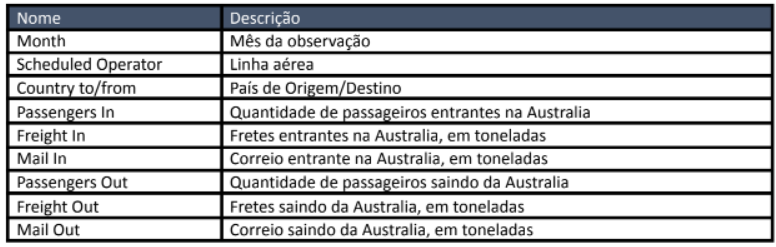

In [363]:
cols = ['Passengers In','Freight In','Mail In','Passengers Out','Freight Out','Mail Out']

for col in cols:
  df[col] = df[col].astype(float)

df.dtypes

Month                 datetime64[ns]
Scheduled Operator            object
Country to/from               object
Passengers In                float64
Freight In                   float64
Mail In                      float64
Passengers Out               float64
Freight Out                  float64
Mail Out                     float64
Year                           int64
dtype: object

Agrupamento por dia (média dos passageiros entrantes)

In [364]:
dff = df.groupby('Month', as_index=False).mean()
dff.head()

,Month,Passengers In,Freight In,Mail In,Passengers Out,Freight Out,Mail Out,Year
0,2009-01-01,14564.511905,283.090607,20.516119,12211.642857,308.328417,12.063440,2009.0
1,2009-02-01,11682.012048,298.484590,19.008398,9922.168675,318.560747,10.953036,2010.0
2,2009-03-01,11435.329268,354.377000,20.761171,11388.329268,345.934049,12.839756,2010.0
3,2009-04-01,11564.333333,317.844310,20.215917,11954.809524,300.515405,10.599024,2010.0
4,2009-05-01,10269.182927,349.714427,22.562061,11249.207317,286.093427,11.731110,2010.0


Visuzalização de gráfico da quantidade total de passageiros saindo do país ao longo do tempo

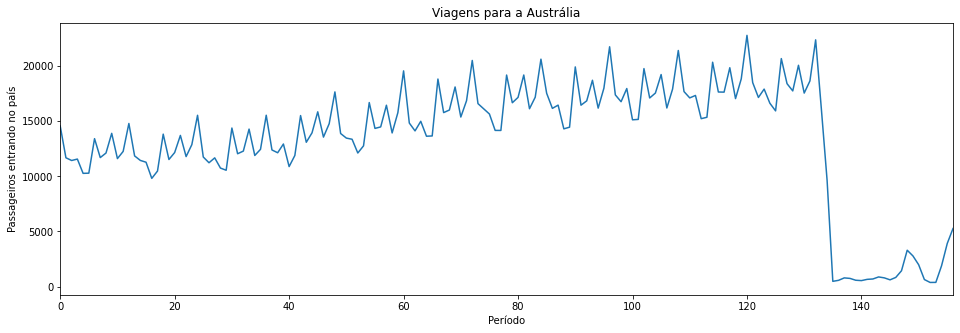

In [365]:
title='Viagens para a Austrália'
ylabel='Passageiros entrando no país'
xlabel='Período'

ax = dff['Passengers In'].plot(figsize=(16,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

Decomposição da série temporal

Text(0.5, 0.98, 'Additive Decompose')

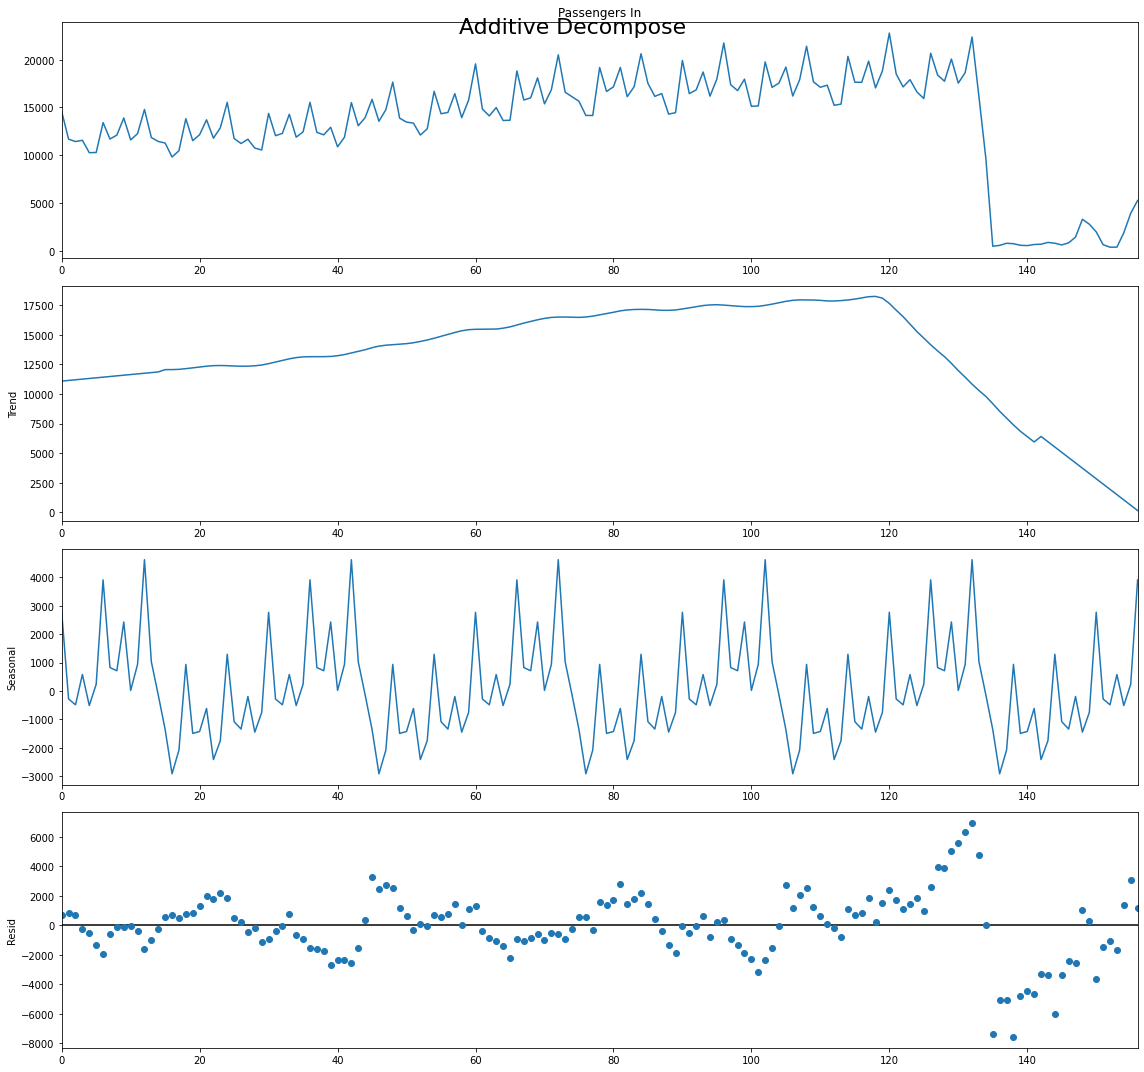

In [366]:
import matplotlib as plt

result_add = seasonal_decompose(x=dff['Passengers In'], model='additive', extrapolate_trend='freq', period=30)
plt.rcParams.update({'figure.figsize': (16,15)})
result_add.plot().suptitle('Additive Decompose', fontsize=22)

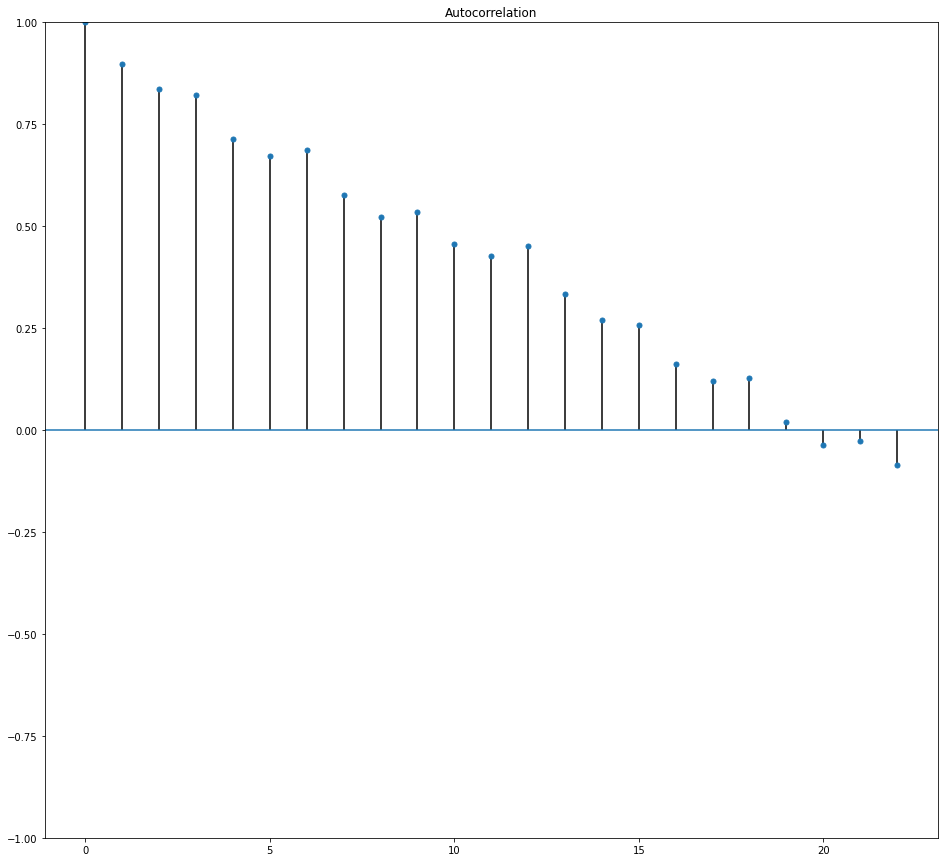

In [367]:
import pmdarima as pm

pm.plot_acf(dff['Passengers In'])

Teste para o modelo estacionário

In [368]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [369]:
adf_test(dff['Passengers In'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -1.792659
p-value                   0.384112
# lags used              13.000000
# observations          143.000000
critical value (1%)      -3.476927
critical value (5%)      -2.881973
critical value (10%)     -2.577665
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


Executar Auto-Arima com variação no fator de sazonalidade "m" para verificar a performance

auto-arima para m=1

In [370]:
auto_arima(dff['Passengers In'], seasonal=True, m=1).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  157
Model:               SARIMAX(3, 1, 2)   Log Likelihood               -1380.236
Date:                Fri, 15 Apr 2022   AIC                           2772.471
Time:                        19:54:01   BIC                           2790.770
Sample:                             0   HQIC                          2779.904
                                - 157                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8536      0.074    -11.569      0.000      -0.998      -0.709
ar.L2         -0.8444      0.065    -13.075      0.000      -0.971      -0.718
ar.L3          0.1366      0.061      2.228      0.026       0.016       0.257
ma.L1          0.9442      0.080     11.836      0.000       0.788       1.101
ma.L2          0.8819      0.050     17.765      0.000       0.785       0.979
sigma2      3.124e+06    2.1e-08   1.48e+14      0.000    3.12e+06    3.12e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):              1039.89
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               4.18   Skew:                            -2.00
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.67e+29. Standard errors may be unstable.
"""

auto-arima para m=7

In [371]:
auto_arima(dff['Passengers In'], seasonal=True, m=7).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  157
Model:             SARIMAX(4, 1, 4)x(1, 0, [1], 7)   Log Likelihood               -1362.428
Date:                             Fri, 15 Apr 2022   AIC                           2746.855
Time:                                     19:57:06   BIC                           2780.404
Sample:                                          0   HQIC                          2760.481
                                             - 157                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0350      0.053     -0.665      0.506      -0.138       0.068
ar.L2         -0.9973      0.054    -18.484      0.000      -1.103      -0.892
ar.L3         -0.0187      0.050     -0.374      0.708      -0.117       0.079
ar.L4         -0.9582      0.050    -19.120      0.000      -1.056      -0.860
ma.L1          0.1050      0.098      1.076      0.282      -0.086       0.296
ma.L2          0.9475      0.118      8.017      0.000       0.716       1.179
ma.L3          0.1153      0.104      1.113      0.266      -0.088       0.318
ma.L4          0.8130      0.121      6.694      0.000       0.575       1.051
ar.S.L7       -0.8964      0.170     -5.276      0.000      -1.229      -0.563
ma.S.L7        0.7792      0.252      3.086      0.002       0.284       1.274
sigma2      2.798e+06      8e-08    3.5e+13      0.000     2.8e+06     2.8e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.45   Jarque-Bera (JB):              1837.50
Prob(Q):                              0.50   Prob(JB):                         0.00
Heteroskedasticity (H):               5.91   Skew:                            -2.64
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.34e+29. Standard errors may be unstable.
"""

auto-arima para m=12



In [373]:
auto_arima(dff['Passengers In'], seasonal=True, m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  157
Model:             SARIMAX(4, 1, 2)x(2, 0, [], 12)   Log Likelihood               -1346.780
Date:                             Fri, 15 Apr 2022   AIC                           2711.559
Time:                                     20:01:23   BIC                           2739.008
Sample:                                          0   HQIC                          2722.708
                                             - 157                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2198      0.159     -1.382      0.167      -0.531       0.092
ar.L2         -0.6323      0.101     -6.268      0.000      -0.830      -0.435
ar.L3          0.2367      0.050      4.739      0.000       0.139       0.335
ar.L4         -0.2239      0.097     -2.315      0.021      -0.413      -0.034
ma.L1          0.3948      0.159      2.482      0.013       0.083       0.707
ma.L2          0.6600      0.136      4.855      0.000       0.394       0.926
ar.S.L12       0.2286      0.047      4.874      0.000       0.137       0.321
ar.S.L24       0.4861      0.060      8.119      0.000       0.369       0.603
sigma2      1.593e+06   8.19e+04     19.451      0.000    1.43e+06    1.75e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.20   Jarque-Bera (JB):              1404.35
Prob(Q):                              0.65   Prob(JB):                         0.00
Heteroskedasticity (H):               4.09   Skew:                            -2.31
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

auto-arima para m=52

In [374]:
auto_arima(dff['Passengers In'], seasonal=True, m=52).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  157
Model:               SARIMAX(3, 1, 2)   Log Likelihood               -1380.236
Date:                Fri, 15 Apr 2022   AIC                           2772.471
Time:                        20:04:45   BIC                           2790.770
Sample:                             0   HQIC                          2779.904
                                - 157                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8536      0.074    -11.569      0.000      -0.998      -0.709
ar.L2         -0.8444      0.065    -13.075      0.000      -0.971      -0.718
ar.L3          0.1366      0.061      2.228      0.026       0.016       0.257
ma.L1          0.9442      0.080     11.836      0.000       0.788       1.101
ma.L2          0.8819      0.050     17.765      0.000       0.785       0.979
sigma2      3.124e+06    2.1e-08   1.48e+14      0.000    3.12e+06    3.12e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):              1039.89
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               4.18   Skew:                            -2.00
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.67e+29. Standard errors may be unstable.
"""

Avaliação do tamanho da base de dados e definir tamanho de base para treino e teste

In [375]:
cut_train = len(dff)-6
print(cut_train)

151


Separação de base de treino e teste

In [376]:
train = dff.iloc[:cut_train]
test = dff.iloc[cut_train:]

Aplicar modelo com parâmetros obtidos anteriormente em auto-arima

Teste para auto-arima com sazonalidade m=1



In [377]:
model_m1 = SARIMAX(train['Passengers In'],order=(3,1,2),enforce_invertibility=False)
results_m1 = model_m1.fit()

Teste para auto-arima com sazonalidade m=7



In [378]:
model_m7 = SARIMAX(train['Passengers In'],order=(4,1,4),seasonal_order=(1,0,1,7),enforce_invertibility=False)
results_m7 = model_m7.fit()

Teste para auto-arima com sazonalidade m=12

In [379]:
model_m12 = SARIMAX(train['Passengers In'],order=(4,1,2),seasonal_order=(2,0,1,12),enforce_invertibility=False)
results_m12 = model_m12.fit()

Teste para auto-arima com sazonalidade m=52

In [380]:
model_m52 = SARIMAX(train['Passengers In'],order=(3,1,2),enforce_invertibility=False)
results_m52 = model_m52.fit()

Obter valores preditos pelo modelo

In [381]:
start=len(train)
end=len(train)+len(test)-1
predictions_m1 = results_m1.predict(start=start, end=end, dynamic=False).rename('SARIMA m=1 Predictions')
predictions_m7 = results_m7.predict(start=start, end=end, dynamic=False).rename('SARIMA m=7 Predictions')
predictions_m12 = results_m12.predict(start=start, end=end, dynamic=False).rename('SARIMA m=12 Predictions')
predictions_m52 = results_m52.predict(start=start, end=end, dynamic=False).rename('SARIMA m=52 Predictions')

Comparar valores reais e preditos pelo modelo

[Text(0, 0.5, 'Passengers In'), Text(0.5, 0, 'Período')]

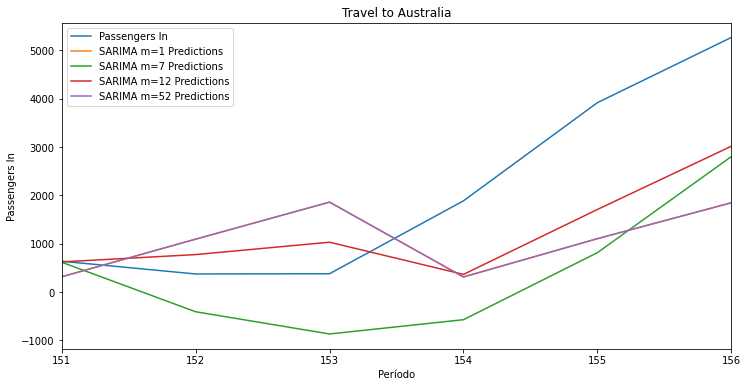

In [382]:
# Plot predictions against known values
title='Travel to Australia'
ylabel='Passengers In'
xlabel='Período'

ax = test['Passengers In'].plot(legend=True,figsize=(12,6),title=title)
ax1 = predictions_m1.plot(legend=True)
ax2 = predictions_m7.plot(legend=True)
ax3 = predictions_m12.plot(legend=True)
ax4 = predictions_m52.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

Avaliar desvio (RMSE) do modelo em relação aos valores reais

In [383]:
from statsmodels.tools.eval_measures import mse,rmse

rmse1 = rmse(test['Passengers In'], predictions_m1)
print(f'SARIMA_m1 RMSE Error: {rmse1}')
cv1=rmse1/dff['Passengers In'].mean()
print(f'SARIMA_m1 CV: {cv1}')

rmse7 = rmse(test['Passengers In'], predictions_m7)
print(f'SARIMA_m7 RMSE Error: {rmse7}')
cv7=rmse7/dff['Passengers In'].mean()
print(f'SARIMA_m7 CV: {cv7}')

rmse12 = rmse(test['Passengers In'], predictions_m12)
print(f'SARIMA_m12 RMSE Error: {rmse12}')
cv12=rmse12/dff['Passengers In'].mean()
print(f'SARIMA_m12 CV: {cv12}')

rmse52 = rmse(test['Passengers In'], predictions_m52)
print(f'SARIMA_m52 RMSE Error: {rmse52}')
cv52=rmse52/dff['Passengers In'].mean()
print(f'SARIMA_m52 CV: {cv52}')

SARIMA_m1 RMSE Error: 2035.9441412221875
SARIMA_m1 CV: 0.15189744792608564
SARIMA_m7 RMSE Error: 1994.9244165300395
SARIMA_m7 CV: 0.14883705379777348
SARIMA_m12 RMSE Error: 1462.3097468066437
SARIMA_m12 CV: 0.10909980982289093
SARIMA_m52 RMSE Error: 2035.9441412221875
SARIMA_m52 CV: 0.15189744792608564


Forecast

t+6

[Text(0, 0.5, 'Passengers In'), Text(0.5, 0, 'Período')]

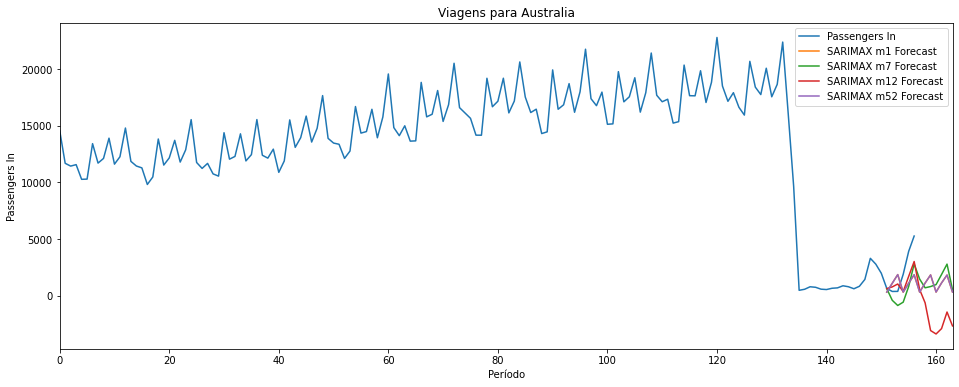

In [405]:
fcast_m1 = results_m1.predict(len(dff)-6,len(dff)+6).rename('SARIMAX m1 Forecast')
fcast_m7 = results_m7.predict(len(dff)-6,len(dff)+6).rename('SARIMAX m7 Forecast')
fcast_m12 = results_m12.predict(len(dff)-6,len(dff)+6).rename('SARIMAX m12 Forecast')
fcast_m52 = results_m52.predict(len(dff)-6,len(dff)+6).rename('SARIMAX m52 Forecast')
title='Viagens para Australia'
ylabel='Passengers In'
xlabel='Período'

ax = dff['Passengers In'].plot(legend=True,figsize=(16,6),title=title)
fcast_m1.plot(legend=True)
fcast_m7.plot(legend=True)
fcast_m12.plot(legend=True)
fcast_m52.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

Previsão por Continente

Utilizar base de dados de países: https://raw.githubusercontent.com/lukes/ISO-3166-Countries-with-Regional-Codes/master/all/all.csv

In [385]:
paises = pd.read_csv('https://raw.githubusercontent.com/lukes/ISO-3166-Countries-with-Regional-Codes/master/all/all.csv')
paises.head()

,name,alpha-2,alpha-3,country-code,iso_3166-2,region,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code
0,Afghanistan,AF,AFG,4,ISO 3166-2:AF,Asia,Southern Asia,NaN,142.0,34.0,NaN
1,Åland Islands,AX,ALA,248,ISO 3166-2:AX,Europe,Northern Europe,NaN,150.0,154.0,NaN
2,Albania,AL,ALB,8,ISO 3166-2:AL,Europe,Southern Europe,NaN,150.0,39.0,NaN
3,Algeria,DZ,DZA,12,ISO 3166-2:DZ,Africa,Northern Africa,NaN,2.0,15.0,NaN
4,American Samoa,AS,ASM,16,ISO 3166-2:AS,Oceania,Polynesia,NaN,9.0,61.0,NaN


Renomear coluna para operação de merge

In [386]:
paises.rename(columns={'name': 'Country to/from'}, inplace=True)
paises

,Country to/from,alpha-2,alpha-3,country-code,iso_3166-2,region,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code
0,Afghanistan,AF,AFG,4,ISO 3166-2:AF,Asia,Southern Asia,NaN,142.0,34.0,NaN
1,Åland Islands,AX,ALA,248,ISO 3166-2:AX,Europe,Northern Europe,NaN,150.0,154.0,NaN
2,Albania,AL,ALB,8,ISO 3166-2:AL,Europe,Southern Europe,NaN,150.0,39.0,NaN
3,Algeria,DZ,DZA,12,ISO 3166-2:DZ,Africa,Northern Africa,NaN,2.0,15.0,NaN
4,American Samoa,AS,ASM,16,ISO 3166-2:AS,Oceania,Polynesia,NaN,9.0,61.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
244,Wallis and Futuna,WF,WLF,876,ISO 3166-2:WF,Oceania,Polynesia,NaN,9.0,61.0,NaN
245,Western Sahara,EH,ESH,732,ISO 3166-2:EH,Africa,Northern Africa,NaN,2.0,15.0,NaN
246,Yemen,YE,YEM,887,ISO 3166-2:YE,Asia,Western Asia,NaN,142.0,145.0,NaN
247,Zambia,ZM,ZMB,894,ISO 3166-2:ZM,Africa,Sub-Saharan Africa,Eastern Africa,2.0,202.0,14.0


Merge para obter informações dos dois dataframes

In [387]:
df_continente = pd.merge(df, 
                      paises, 
                      on ='Country to/from', 
                      how ='inner')

Exclusão de colunas irrelevantes para o estudo

In [388]:
columns = ['alpha-2', 'alpha-3', 'country-code', 'iso_3166-2', 'sub-region', 'intermediate-region', 'region', 'sub-region-code', 'intermediate-region-code']
df_continente.drop(columns, axis=1, inplace=True)

Visualização das primeiras linhas da base com os dados de interesse

In [389]:
df_continente.head()

,Month,Scheduled Operator,Country to/from,Passengers In,Freight In,Mail In,Passengers Out,Freight Out,Mail Out,Year,region-code
0,2009-01-01,Aerolineas Argentinas,Argentina,3021.0,4.313,0.6,1959.0,8.311,0.000,2009,19.0
1,2009-01-01,Qantas Airways,Argentina,3755.0,7.773,0.0,2668.0,6.342,0.790,2009,19.0
2,2009-02-01,Aerolineas Argentinas,Argentina,2600.0,3.989,0.7,2226.0,8.777,0.000,2010,19.0
3,2009-02-01,Qantas Airways,Argentina,2875.0,13.632,0.0,3738.0,19.778,0.784,2010,19.0
4,2009-03-01,Aerolineas Argentinas,Argentina,2775.0,11.312,0.9,1781.0,9.778,0.000,2010,19.0


Agrupamento de paises para verificar qual o código de cada um

In [390]:
paises = paises.groupby('region', as_index=False).mean()
paises.head()

,region,country-code,region-code,sub-region-code,intermediate-region-code
0,Africa,455.150000,2.0,180.183333,13.924528
1,Americas,398.824561,19.0,384.087719,19.153846
2,Asia,420.627451,142.0,83.450980,NaN
3,Europe,448.784314,150.0,117.509804,830.000000
4,Oceania,470.103448,9.0,57.034483,NaN


Criação de dataframes por origem

In [391]:
df_africa = df_continente[df_continente['region-code'] == 2.0]
df_africa = df_africa.groupby('Month', as_index=False).mean()
df_americas = df_continente[df_continente['region-code'] == 19.0]
df_americas = df_americas.groupby('Month', as_index=False).mean()
df_asia = df_continente[df_continente['region-code'] == 142.0]
df_asia = df_asia.groupby('Month', as_index=False).mean()
df_europe = df_continente[df_continente['region-code'] == 150.0]
df_europe = df_europe.groupby('Month', as_index=False).mean()
df_oceania = df_continente[df_continente['region-code'] == 9.0]
df_oceania = df_oceania.groupby('Month', as_index=False).mean()

Previsão por origem

Definição de base de treino por origem

In [407]:
train_africa = df_africa.iloc[:len(df_africa)-6]
train_americas = df_americas.iloc[:len(df_americas)-6]
train_asia = df_asia.iloc[:len(df_asia)-6]
train_europe = df_europe.iloc[:len(df_europe)-6]
train_oceania = df_oceania.iloc[:len(df_oceania)-6]

test_africa = df_africa.iloc[len(df_africa)-6:]
test_americas = df_americas.iloc[len(df_americas)-6:]
test_asia = df_asia.iloc[len(df_asia)-6:]
test_europe = df_europe.iloc[len(df_europe)-6:]
test_oceania = df_oceania.iloc[len(df_oceania)-6:]

Previsão para Africa

SARIMA_m1 RMSE Error: 3735.5722843702447
SARIMA_m1 CV: 0.2787030768921934
SARIMA_m7 RMSE Error: 3683.116652052961
SARIMA_m7 CV: 0.27478947409876836
SARIMA_m12 RMSE Error: 3672.642248685935
SARIMA_m12 CV: 0.2740080012146231
SARIMA_m52 RMSE Error: 3735.5722843702447
SARIMA_m52 CV: 0.2787030768921934


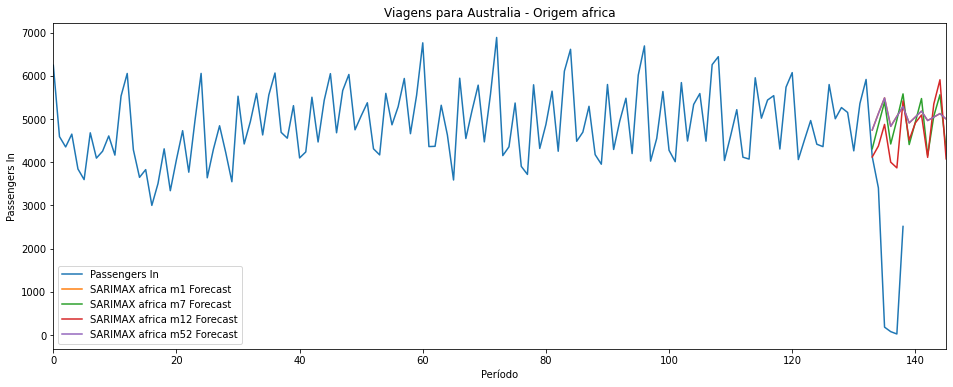

In [408]:
m1_africa = SARIMAX(train_africa['Passengers In'],order=(3,1,2),enforce_invertibility=False)
m7_africa = SARIMAX(train_africa['Passengers In'],order=(4,1,4),seasonal_order=(1,0,1,7),enforce_invertibility=False)
m12_africa = SARIMAX(train_africa['Passengers In'],order=(4,1,2),seasonal_order=(1,0,1,12),enforce_invertibility=False)
m52_africa = SARIMAX(train_africa['Passengers In'],order=(3,1,2),enforce_invertibility=False)
results_m1_africa = m1_africa.fit()
results_m7_africa = m7_africa.fit()
results_m12_africa = m12_africa.fit()
results_m52_africa = m52_africa.fit()

fcast_m1_africa = results_m1_africa.predict(len(df_africa)-6,len(df_africa)+6).rename('SARIMAX africa m1 Forecast')
fcast_m7_africa = results_m7_africa.predict(len(df_africa)-6,len(df_africa)+6).rename('SARIMAX africa m7 Forecast')
fcast_m12_africa = results_m12_africa.predict(len(df_africa)-6,len(df_africa)+6).rename('SARIMAX africa m12 Forecast')
fcast_m52_africa = results_m52_africa.predict(len(df_africa)-6,len(df_africa)+6).rename('SARIMAX africa m52 Forecast')

title='Viagens para Australia - Origem africa'
ylabel='Passengers In'
xlabel='Período'

ax = df_africa['Passengers In'].plot(legend=True,figsize=(16,6),title=title)
fcast_m1_africa.plot(legend=True)
fcast_m7_africa.plot(legend=True)
fcast_m12_africa.plot(legend=True)
fcast_m52_africa.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

predictions_m1 = results_m1_africa.predict(start=start, end=end, dynamic=False).rename('SARIMA m=1 Predictions')
predictions_m7 = results_m7_africa.predict(start=start, end=end, dynamic=False).rename('SARIMA m=7 Predictions')
predictions_m12 = results_m12_africa.predict(start=start, end=end, dynamic=False).rename('SARIMA m=12 Predictions')
predictions_m52 = results_m52_africa.predict(start=start, end=end, dynamic=False).rename('SARIMA m=52 Predictions')

rmse1 = rmse(test_africa['Passengers In'], predictions_m1)
print(f'SARIMA_m1 RMSE Error: {rmse1}')
cv1=rmse1/dff['Passengers In'].mean()
print(f'SARIMA_m1 CV: {cv1}')

rmse7 = rmse(test_africa['Passengers In'], predictions_m7)
print(f'SARIMA_m7 RMSE Error: {rmse7}')
cv7=rmse7/dff['Passengers In'].mean()
print(f'SARIMA_m7 CV: {cv7}')

rmse12 = rmse(test_africa['Passengers In'], predictions_m12)
print(f'SARIMA_m12 RMSE Error: {rmse12}')
cv12=rmse12/dff['Passengers In'].mean()
print(f'SARIMA_m12 CV: {cv12}')

rmse52 = rmse(test_africa['Passengers In'], predictions_m52)
print(f'SARIMA_m52 RMSE Error: {rmse52}')
cv52=rmse52/dff['Passengers In'].mean()
print(f'SARIMA_m52 CV: {cv52}')

Previsão para Americas

SARIMA_m1 RMSE Error: 1452.1866455963113
SARIMA_m1 CV: 0.1083445468430216
SARIMA_m7 RMSE Error: 3514.7476886462528
SARIMA_m7 CV: 0.262227825017332
SARIMA_m12 RMSE Error: 3760.4087921180417
SARIMA_m12 CV: 0.28055607573725116
SARIMA_m52 RMSE Error: 1452.1866455963113
SARIMA_m52 CV: 0.1083445468430216


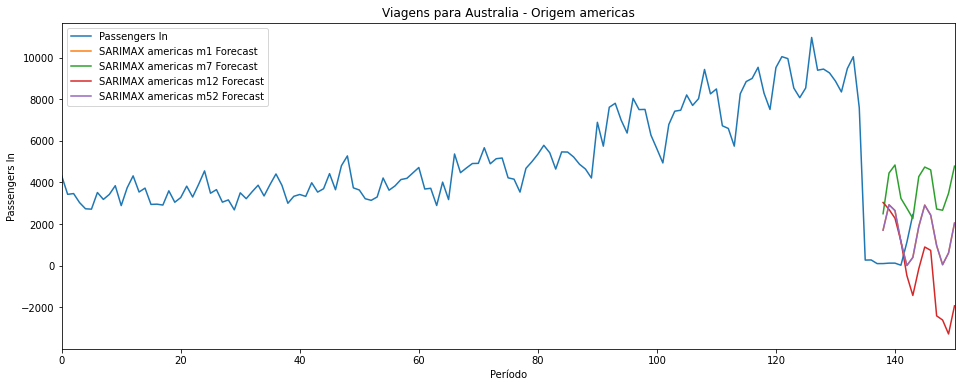

In [409]:
m1_americas = SARIMAX(train_americas['Passengers In'],order=(3,1,2),enforce_invertibility=False)
m7_americas = SARIMAX(train_americas['Passengers In'],order=(4,1,4),seasonal_order=(1,0,1,7),enforce_invertibility=False)
m12_americas = SARIMAX(train_americas['Passengers In'],order=(4,1,2),seasonal_order=(1,0,1,12),enforce_invertibility=False)
m52_americas = SARIMAX(train_americas['Passengers In'],order=(3,1,2),enforce_invertibility=False)
results_m1_americas = m1_americas.fit()
results_m7_americas = m7_americas.fit()
results_m12_americas = m12_americas.fit()
results_m52_americas = m52_americas.fit()

fcast_m1_americas = results_m1_americas.predict(len(df_americas)-6,len(df_americas)+6).rename('SARIMAX americas m1 Forecast')
fcast_m7_americas = results_m7_americas.predict(len(df_americas)-6,len(df_americas)+6).rename('SARIMAX americas m7 Forecast')
fcast_m12_americas = results_m12_americas.predict(len(df_americas)-6,len(df_americas)+6).rename('SARIMAX americas m12 Forecast')
fcast_m52_americas = results_m52_americas.predict(len(df_americas)-6,len(df_americas)+6).rename('SARIMAX americas m52 Forecast')

title='Viagens para Australia - Origem americas'
ylabel='Passengers In'
xlabel='Período'

ax = df_americas['Passengers In'].plot(legend=True,figsize=(16,6),title=title)
fcast_m1_americas.plot(legend=True)
fcast_m7_americas.plot(legend=True)
fcast_m12_americas.plot(legend=True)
fcast_m52_americas.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

predictions_m1 = results_m1_americas.predict(start=start, end=end, dynamic=False).rename('SARIMA m=1 Predictions')
predictions_m7 = results_m7_americas.predict(start=start, end=end, dynamic=False).rename('SARIMA m=7 Predictions')
predictions_m12 = results_m12_americas.predict(start=start, end=end, dynamic=False).rename('SARIMA m=12 Predictions')
predictions_m52 = results_m52_americas.predict(start=start, end=end, dynamic=False).rename('SARIMA m=52 Predictions')

rmse1 = rmse(test_americas['Passengers In'], predictions_m1)
print(f'SARIMA_m1 RMSE Error: {rmse1}')
cv1=rmse1/dff['Passengers In'].mean()
print(f'SARIMA_m1 CV: {cv1}')

rmse7 = rmse(test_americas['Passengers In'], predictions_m7)
print(f'SARIMA_m7 RMSE Error: {rmse7}')
cv7=rmse7/dff['Passengers In'].mean()
print(f'SARIMA_m7 CV: {cv7}')

rmse12 = rmse(test_americas['Passengers In'], predictions_m12)
print(f'SARIMA_m12 RMSE Error: {rmse12}')
cv12=rmse12/dff['Passengers In'].mean()
print(f'SARIMA_m12 CV: {cv12}')

rmse52 = rmse(test_americas['Passengers In'], predictions_m52)
print(f'SARIMA_m52 RMSE Error: {rmse52}')
cv52=rmse52/dff['Passengers In'].mean()
print(f'SARIMA_m52 CV: {cv52}')

Previsão para Asia

SARIMA_m1 RMSE Error: 4287.525856766998
SARIMA_m1 CV: 0.31988315512873233
SARIMA_m7 RMSE Error: 4925.651165601307
SARIMA_m7 CV: 0.3674923227411549
SARIMA_m12 RMSE Error: 4220.429582390397
SARIMA_m12 CV: 0.3148772452725631
SARIMA_m52 RMSE Error: 4287.525856766998
SARIMA_m52 CV: 0.31988315512873233


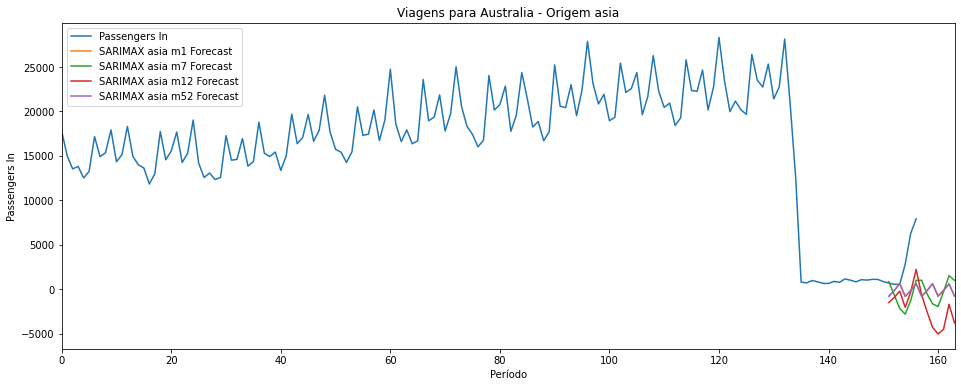

In [410]:
m1_asia = SARIMAX(train_asia['Passengers In'],order=(3,1,2),enforce_invertibility=False)
m7_asia = SARIMAX(train_asia['Passengers In'],order=(4,1,4),seasonal_order=(1,0,1,7),enforce_invertibility=False)
m12_asia = SARIMAX(train_asia['Passengers In'],order=(4,1,2),seasonal_order=(1,0,1,12),enforce_invertibility=False)
m52_asia = SARIMAX(train_asia['Passengers In'],order=(3,1,2),enforce_invertibility=False)
results_m1_asia = m1_asia.fit()
results_m7_asia = m7_asia.fit()
results_m12_asia = m12_asia.fit()
results_m52_asia = m52_asia.fit()

fcast_m1_asia = results_m1_asia.predict(len(df_asia)-6,len(df_asia)+6).rename('SARIMAX asia m1 Forecast')
fcast_m7_asia = results_m7_asia.predict(len(df_asia)-6,len(df_asia)+6).rename('SARIMAX asia m7 Forecast')
fcast_m12_asia = results_m12_asia.predict(len(df_asia)-6,len(df_asia)+6).rename('SARIMAX asia m12 Forecast')
fcast_m52_asia = results_m52_asia.predict(len(df_asia)-6,len(df_asia)+6).rename('SARIMAX asia m52 Forecast')

title='Viagens para Australia - Origem asia'
ylabel='Passengers In'
xlabel='Período'

ax = df_asia['Passengers In'].plot(legend=True,figsize=(16,6),title=title)
fcast_m1_asia.plot(legend=True)
fcast_m7_asia.plot(legend=True)
fcast_m12_asia.plot(legend=True)
fcast_m52_asia.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

predictions_m1 = results_m1_asia.predict(start=start, end=end, dynamic=False).rename('SARIMA m=1 Predictions')
predictions_m7 = results_m7_asia.predict(start=start, end=end, dynamic=False).rename('SARIMA m=7 Predictions')
predictions_m12 = results_m12_asia.predict(start=start, end=end, dynamic=False).rename('SARIMA m=12 Predictions')
predictions_m52 = results_m52_asia.predict(start=start, end=end, dynamic=False).rename('SARIMA m=52 Predictions')

rmse1 = rmse(test_asia['Passengers In'], predictions_m1)
print(f'SARIMA_m1 RMSE Error: {rmse1}')
cv1=rmse1/dff['Passengers In'].mean()
print(f'SARIMA_m1 CV: {cv1}')

rmse7 = rmse(test_asia['Passengers In'], predictions_m7)
print(f'SARIMA_m7 RMSE Error: {rmse7}')
cv7=rmse7/dff['Passengers In'].mean()
print(f'SARIMA_m7 CV: {cv7}')

rmse12 = rmse(test_asia['Passengers In'], predictions_m12)
print(f'SARIMA_m12 RMSE Error: {rmse12}')
cv12=rmse12/dff['Passengers In'].mean()
print(f'SARIMA_m12 CV: {cv12}')

rmse52 = rmse(test_asia['Passengers In'], predictions_m52)
print(f'SARIMA_m52 RMSE Error: {rmse52}')
cv52=rmse52/dff['Passengers In'].mean()
print(f'SARIMA_m52 CV: {cv52}')

Previsão para Europe

SARIMA_m1 RMSE Error: 1136.375774533493
SARIMA_m1 CV: 0.08478257165397785
SARIMA_m7 RMSE Error: 1137.1324319537214
SARIMA_m7 CV: 0.08483902424948865
SARIMA_m52 RMSE Error: 1136.375774533493
SARIMA_m52 CV: 0.08478257165397785


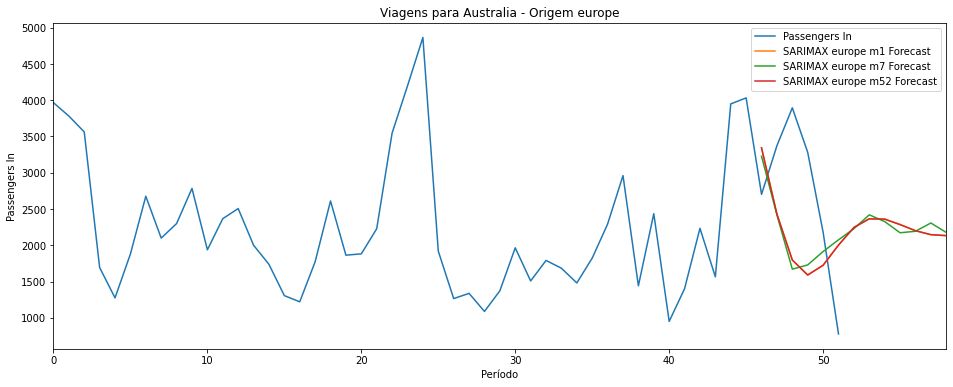

In [412]:
m1_europe = SARIMAX(train_europe['Passengers In'],order=(3,1,2),enforce_invertibility=False)
m7_europe = SARIMAX(train_europe['Passengers In'],order=(4,1,4),seasonal_order=(1,0,1,7),enforce_invertibility=False)
m52_europe = SARIMAX(train_europe['Passengers In'],order=(3,1,2),enforce_invertibility=False)
results_m1_europe = m1_europe.fit()
results_m7_europe = m7_europe.fit()
results_m52_europe = m52_europe.fit()

fcast_m1_europe = results_m1_europe.predict(len(df_europe)-6,len(df_europe)+6).rename('SARIMAX europe m1 Forecast')
fcast_m7_europe = results_m7_europe.predict(len(df_europe)-6,len(df_europe)+6).rename('SARIMAX europe m7 Forecast')
fcast_m52_europe = results_m52_europe.predict(len(df_europe)-6,len(df_europe)+6).rename('SARIMAX europe m52 Forecast')

title='Viagens para Australia - Origem europe'
ylabel='Passengers In'
xlabel='Período'

ax = df_europe['Passengers In'].plot(legend=True,figsize=(16,6),title=title)
fcast_m1_europe.plot(legend=True)
fcast_m7_europe.plot(legend=True)
fcast_m52_europe.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

predictions_m1 = results_m1_europe.predict(start=start, end=end, dynamic=False).rename('SARIMA m=1 Predictions')
predictions_m7 = results_m7_europe.predict(start=start, end=end, dynamic=False).rename('SARIMA m=7 Predictions')
predictions_m52 = results_m52_europe.predict(start=start, end=end, dynamic=False).rename('SARIMA m=52 Predictions')

rmse1 = rmse(test_europe['Passengers In'], predictions_m1)
print(f'SARIMA_m1 RMSE Error: {rmse1}')
cv1=rmse1/dff['Passengers In'].mean()
print(f'SARIMA_m1 CV: {cv1}')

rmse7 = rmse(test_europe['Passengers In'], predictions_m7)
print(f'SARIMA_m7 RMSE Error: {rmse7}')
cv7=rmse7/dff['Passengers In'].mean()
print(f'SARIMA_m7 CV: {cv7}')

rmse52 = rmse(test_europe['Passengers In'], predictions_m52)
print(f'SARIMA_m52 RMSE Error: {rmse52}')
cv52=rmse52/dff['Passengers In'].mean()
print(f'SARIMA_m52 CV: {cv52}')

Previsão para Oceania

SARIMA_m1 RMSE Error: 6324.875127298411
SARIMA_m1 CV: 0.47188543675420885
SARIMA_m7 RMSE Error: 5804.32338292998
SARIMA_m7 CV: 0.4330481818992842
SARIMA_m52 RMSE Error: 6324.875127298411
SARIMA_m52 CV: 0.47188543675420885


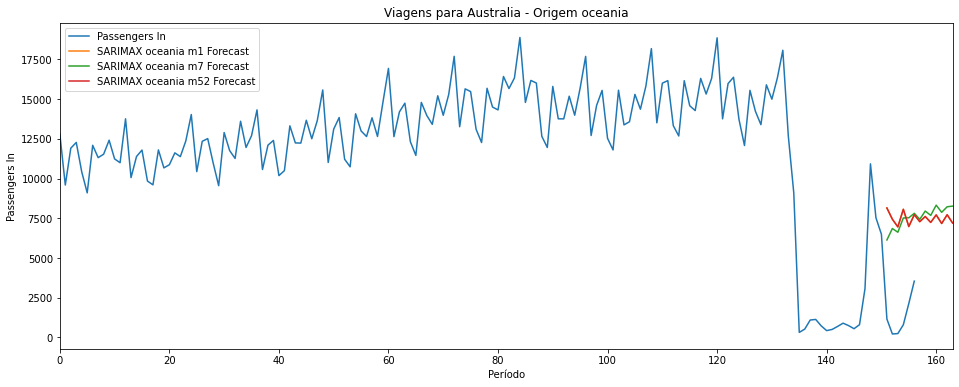

In [414]:
m1_oceania = SARIMAX(train_oceania['Passengers In'],order=(3,1,2),enforce_invertibility=False)
m7_oceania = SARIMAX(train_oceania['Passengers In'],order=(4,1,4),seasonal_order=(1,0,1,7),enforce_invertibility=False)
m52_oceania = SARIMAX(train_oceania['Passengers In'],order=(3,1,2),enforce_invertibility=False)
results_m1_oceania = m1_oceania.fit()
results_m7_oceania = m7_oceania.fit()
results_m52_oceania = m52_oceania.fit()

fcast_m1_oceania = results_m1_oceania.predict(len(df_oceania)-6,len(df_oceania)+6).rename('SARIMAX oceania m1 Forecast')
fcast_m7_oceania = results_m7_oceania.predict(len(df_oceania)-6,len(df_oceania)+6).rename('SARIMAX oceania m7 Forecast')
fcast_m52_oceania = results_m52_oceania.predict(len(df_oceania)-6,len(df_oceania)+6).rename('SARIMAX oceania m52 Forecast')

title='Viagens para Australia - Origem oceania'
ylabel='Passengers In'
xlabel='Período'

ax = df_oceania['Passengers In'].plot(legend=True,figsize=(16,6),title=title)
fcast_m1_oceania.plot(legend=True)
fcast_m7_oceania.plot(legend=True)
fcast_m52_oceania.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

predictions_m1 = results_m1_oceania.predict(start=start, end=end, dynamic=False).rename('SARIMA m=1 Predictions')
predictions_m7 = results_m7_oceania.predict(start=start, end=end, dynamic=False).rename('SARIMA m=7 Predictions')
predictions_m52 = results_m52_oceania.predict(start=start, end=end, dynamic=False).rename('SARIMA m=52 Predictions')

rmse1 = rmse(test_oceania['Passengers In'], predictions_m1)
print(f'SARIMA_m1 RMSE Error: {rmse1}')
cv1=rmse1/dff['Passengers In'].mean()
print(f'SARIMA_m1 CV: {cv1}')

rmse7 = rmse(test_oceania['Passengers In'], predictions_m7)
print(f'SARIMA_m7 RMSE Error: {rmse7}')
cv7=rmse7/dff['Passengers In'].mean()
print(f'SARIMA_m7 CV: {cv7}')

rmse52 = rmse(test_oceania['Passengers In'], predictions_m52)
print(f'SARIMA_m52 RMSE Error: {rmse52}')
cv52=rmse52/dff['Passengers In'].mean()
print(f'SARIMA_m52 CV: {cv52}')

In [415]:
import pickle
filename = 'model_m12.pkl'
pickle.dump(model_m12, open(filename, 'wb'))

filename = 'm7_africa.pkl'
pickle.dump(m7_africa, open(filename, 'wb'))

filename = 'm1_americas.pkl'
pickle.dump(m1_americas, open(filename, 'wb'))

filename = 'm12_asia.pkl'
pickle.dump(m12_asia, open(filename, 'wb'))

filename = 'm1_europe.pkl'
pickle.dump(m1_europe, open(filename, 'wb'))

filename = 'm7_oceania.pkl'
pickle.dump(m7_oceania, open(filename, 'wb'))